In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

In [2]:
plt.style.use("seaborn")

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/eap_2021_access.csv")
IND_u= pd.read_csv('../Datasets/eap_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

0    8014
1    3565
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,1,5.0,1,3
1,1,6.0,1,3
2,1,3.0,1,2
3,2,4.0,1,5
4,1,2.0,1,5
...,...,...,...,...
11574,1,6.0,3,3
11575,2,4.0,3,5
11576,2,3.0,3,5
11577,1,3.0,3,5


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,980,834,719,609,468
2,684,897,1138,1256,1227
3,154,256,451,721,1185


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

## Implementing MCA

In [8]:
mca_a = prince.MCA(n_components=9)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9
0,1.497367,-0.160795,-0.041400,0.025701,-0.160175,-0.123701,-0.762817,-0.130758,-0.012479
1,2.138453,1.166001,0.491754,-0.099013,0.277264,0.162875,0.413639,-0.072579,0.063087
2,2.138453,1.166001,0.491754,-0.099013,0.277264,0.162875,0.413639,-0.072579,0.063087
3,1.497367,-0.160795,-0.041400,0.025701,-0.160175,-0.123701,-0.762817,-0.130758,-0.012479
4,-0.295862,0.039714,-0.077776,0.123741,0.102815,-0.565042,0.122086,-0.062914,-0.136472
...,...,...,...,...,...,...,...,...,...
11574,0.881973,0.241306,-0.134861,0.010627,-0.237999,-0.224958,-0.801265,0.468059,-0.284297
11575,-0.554690,-0.030113,0.518414,0.750121,-0.069228,0.659194,-0.092601,-0.045698,-0.208687
11576,-0.576946,-0.133472,0.702543,0.037334,0.346671,0.192227,-0.164373,-0.018646,-0.220680
11577,-0.533857,0.020477,0.196392,0.223886,-0.357073,1.058784,-0.058805,-0.094762,-0.207463


In [9]:
mca_u = prince.MCA(n_components=28)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC19,uPC20,uPC21,uPC22,uPC23,uPC24,uPC25,uPC26,uPC27,uPC28
0,-0.833325,-0.602807,0.119351,-0.231443,0.022972,0.028846,-0.105013,-0.144106,0.057784,-0.059187,...,-0.175247,-0.123333,0.087641,0.152583,0.009221,0.041370,-0.100820,0.021565,0.035625,0.046558
1,-0.942948,-0.149088,0.230151,0.221438,-0.031760,-0.266352,-0.249534,-0.048977,-0.009982,-0.043538,...,-0.020418,0.014949,-0.022388,-0.056095,0.009127,0.003172,-0.012819,-0.006102,-0.010055,0.012580
2,-0.942948,-0.149088,0.230151,0.221438,-0.031760,-0.266352,-0.249534,-0.048977,-0.009982,-0.043538,...,-0.020418,0.014949,-0.022388,-0.056095,0.009127,0.003172,-0.012819,-0.006102,-0.010055,0.012580
3,-0.615633,-0.343135,0.399367,-0.414160,-0.008564,0.283560,0.343506,-0.207902,0.060004,0.055328,...,0.175376,0.009818,-0.006195,-0.018942,0.029624,-0.022930,0.018941,0.036066,-0.008691,0.070337
4,-0.319936,-0.154236,-0.343764,-0.337758,0.051118,-0.122484,-0.119975,-0.079885,0.021633,-0.073087,...,-0.202685,0.023935,-0.151626,0.260570,-0.009302,0.045263,-0.144607,-0.032276,0.118761,-0.028963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11574,-0.755095,-0.083409,0.048922,0.127706,0.008604,-0.512164,-0.011398,-0.045209,0.007916,-0.049136,...,-0.043672,0.203874,0.128557,0.015817,0.095268,-0.050848,0.197356,0.040047,0.037573,-0.024657
11575,0.739487,-0.282696,-0.163150,0.115266,0.018804,-0.109243,0.273849,0.030724,0.014735,0.258992,...,0.254127,-0.023595,0.036059,0.049265,0.365139,-0.011079,-0.007411,0.175205,0.170134,0.018170
11576,0.724306,-0.263995,-0.167336,0.264237,-0.014842,0.044719,0.013650,0.002442,-0.008818,0.123980,...,0.231358,0.277021,0.109662,-0.227341,0.346697,0.014171,-0.182095,0.071831,0.005294,0.136015
11577,0.858621,-0.311845,-0.061234,0.007364,0.034066,-0.182866,0.243576,0.090196,-0.010175,0.083364,...,0.292391,-0.029261,-0.076985,0.071775,0.177092,0.003455,-0.100192,0.054470,-0.001211,0.051738


In [10]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9,uPC1,...,uPC23,uPC24,uPC25,uPC26,uPC27,uPC28,female,age,educ,inc_q
0,1.497367,-0.160795,-0.041400,0.025701,-0.160175,-0.123701,-0.762817,-0.130758,-0.012479,-0.833325,...,0.009221,0.041370,-0.100820,0.021565,0.035625,0.046558,1,5.0,1,3
1,2.138453,1.166001,0.491754,-0.099013,0.277264,0.162875,0.413639,-0.072579,0.063087,-0.942948,...,0.009127,0.003172,-0.012819,-0.006102,-0.010055,0.012580,1,6.0,1,3
2,2.138453,1.166001,0.491754,-0.099013,0.277264,0.162875,0.413639,-0.072579,0.063087,-0.942948,...,0.009127,0.003172,-0.012819,-0.006102,-0.010055,0.012580,1,3.0,1,2
3,1.497367,-0.160795,-0.041400,0.025701,-0.160175,-0.123701,-0.762817,-0.130758,-0.012479,-0.615633,...,0.029624,-0.022930,0.018941,0.036066,-0.008691,0.070337,2,4.0,1,5
4,-0.295862,0.039714,-0.077776,0.123741,0.102815,-0.565042,0.122086,-0.062914,-0.136472,-0.319936,...,-0.009302,0.045263,-0.144607,-0.032276,0.118761,-0.028963,1,2.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11574,0.881973,0.241306,-0.134861,0.010627,-0.237999,-0.224958,-0.801265,0.468059,-0.284297,-0.755095,...,0.095268,-0.050848,0.197356,0.040047,0.037573,-0.024657,1,6.0,3,3
11575,-0.554690,-0.030113,0.518414,0.750121,-0.069228,0.659194,-0.092601,-0.045698,-0.208687,0.739487,...,0.365139,-0.011079,-0.007411,0.175205,0.170134,0.018170,2,4.0,3,5
11576,-0.576946,-0.133472,0.702543,0.037334,0.346671,0.192227,-0.164373,-0.018646,-0.220680,0.724306,...,0.346697,0.014171,-0.182095,0.071831,0.005294,0.136015,2,3.0,3,5
11577,-0.533857,0.020477,0.196392,0.223886,-0.357073,1.058784,-0.058805,-0.094762,-0.207463,0.858621,...,0.177092,0.003455,-0.100192,0.054470,-0.001211,0.051738,1,3.0,3,5


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [12]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .69, 1: .69}], 
              'C': [100]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END .............C=100, class_weight={0: 0.69, 1: 0.69}; total time=   0.1s
[CV] END .............C=100, class_weight={0: 0.69, 1: 0.69}; total time=   0.1s
[CV] END .............C=100, class_weight={0: 0.69, 1: 0.69}; total time=   0.1s
[CV] END .............C=100, class_weight={0: 0.69, 1: 0.69}; total time=   0.1s
[CV] END .............C=100, class_weight={0: 0.69, 1: 0.69}; total time=   0.1s


In [13]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 100, 'class_weight': {0: 0.69, 1: 0.69}}
Best score: 0.916134690580056


In [14]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_)
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9805132415013447
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1602
           1       0.88      0.96      0.91       714

    accuracy                           0.95      2316
   macro avg       0.93      0.95      0.94      2316
weighted avg       0.95      0.95      0.95      2316



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [15]:
acc= accuracy_score(y_test, y_pred)
pre= precision_score(y_test, y_pred)
rec= recall_score(y_test, y_pred)
f_1= f1_score(y_test, y_pred)
acc, rec, pre, f_1, auc1

(0.9451640759930915,
 0.9551820728291317,
 0.8777348777348777,
 0.9148222669349431,
 0.9805132415013447)

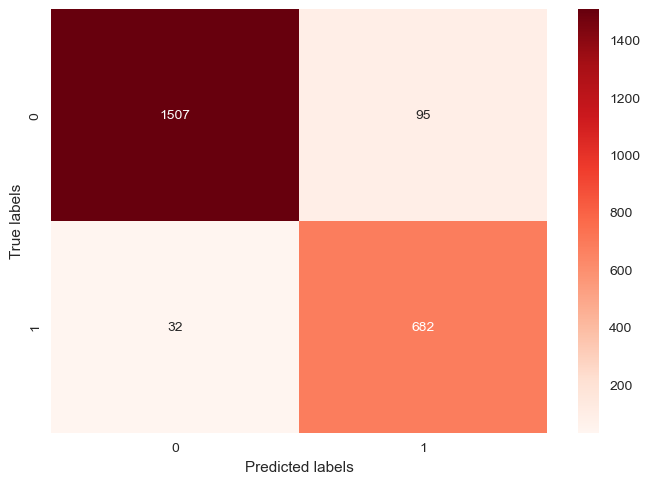

In [16]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [17]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

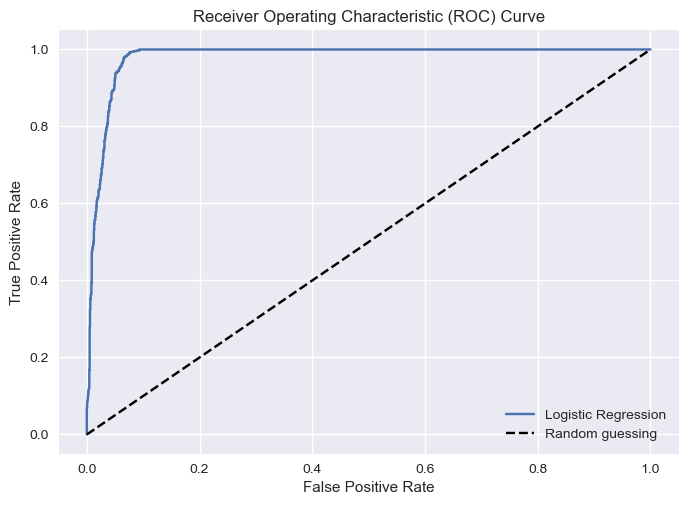

In [18]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [19]:
weights= [i for i in np.linspace(0, 1,100)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [i for i in range(173,174)],
    'max_depth': [i for i in range(14,15)],
    'min_samples_split': [i for i in range(2,3)],
    'min_samples_leaf': [i for i in range(2,3)],
    'max_features': ['sqrt'],
    'class_weight': [{0: .39 , 1: .56} ]
}
rf = RandomForestClassifier(random_state= 42)

In [20]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Best hyperparameters: {'class_weight': {0: 0.39, 1: 0.56}, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 173}
Best score: 0.8843879338883818


In [21]:
auc2 = roc_auc_score(y_test, proba[:,1])
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9722340246960207
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1602
           1       0.89      0.88      0.88       714

    accuracy                           0.93      2316
   macro avg       0.92      0.92      0.92      2316
weighted avg       0.93      0.93      0.93      2316



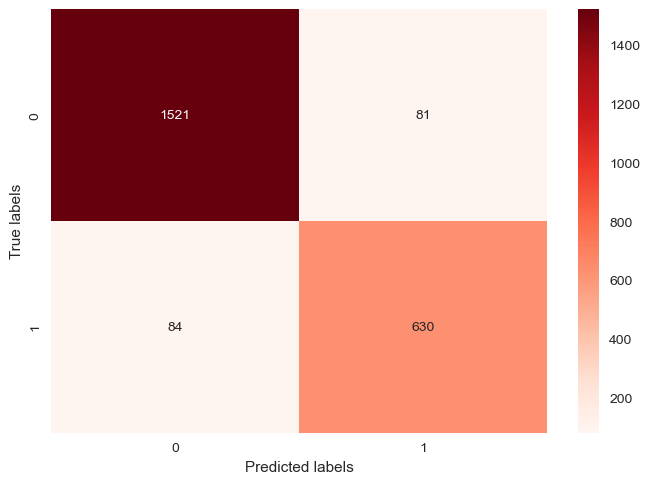

In [22]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [23]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

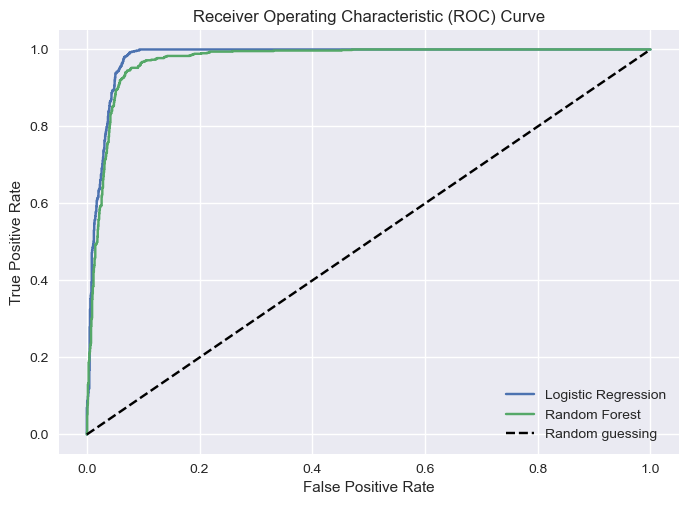

In [24]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [25]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [26]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [i for i in  range(2,3)],
    'learning_rate': [.1**i for i in  range(1, 2)],
    'n_estimators': [i for i in  range(503,504)],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=2, n_estimators=503, reg_alpha=0.5, reg_lambda=0.1, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=2, n_estimators=503, reg_alpha=0.5, reg_lambda=0.1, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=2, n_estimators=503, reg_alpha=0.5, reg_lambda=0.1, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=2, n_estimators=503, reg_alpha=0.5, reg_lambda=0.1, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=2, n_estimators=503, reg_alpha=0.5, reg_lambda=0.1, subsample=0.5; total time=   0.4s
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 503, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.9119724699024425


In [27]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [28]:
auc3 = roc_auc_score(y_test, y_)
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9794309109411555
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1602
           1       0.88      0.94      0.91       714

    accuracy                           0.94      2316
   macro avg       0.93      0.94      0.93      2316
weighted avg       0.94      0.94      0.94      2316



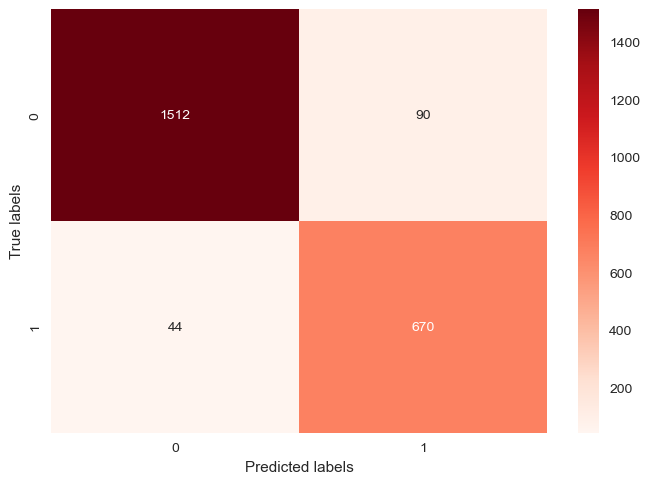

In [29]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [30]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

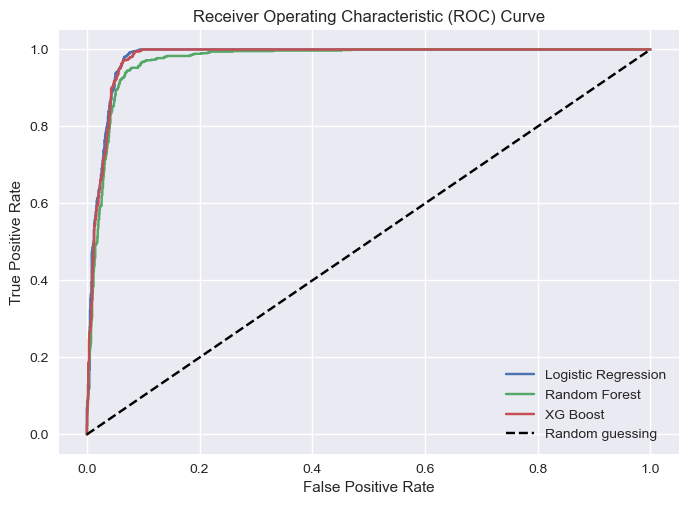

In [31]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [32]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [33]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [34]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
232/232 [==============================] - 0s 899us/step - loss: 0.3697 - precision: 0.8236 - recall: 0.5701 - val_loss: 0.2008 - val_precision: 0.8879 - val_recall: 0.8864
Epoch 2/50
232/232 [==============================] - 0s 530us/step - loss: 0.1627 - precision: 0.8690 - recall: 0.9385 - val_loss: 0.1618 - val_precision: 0.8850 - val_recall: 0.9390
Epoch 3/50
232/232 [==============================] - 0s 551us/step - loss: 0.1485 - precision: 0.8699 - recall: 0.9584 - val_loss: 0.1525 - val_precision: 0.8647 - val_recall: 0.9644
Epoch 4/50
232/232 [==============================] - 0s 525us/step - loss: 0.1417 - precision: 0.8729 - recall: 0.9598 - val_loss: 0.1499 - val_precision: 0.8682 - val_recall: 0.9712
Epoch 5/50
232/232 [==============================] - 0s 518us/step - loss: 0.1392 - precision: 0.8749 - recall: 0.9562 - val_loss: 0.1465 - val_precision: 0.8716 - val_recall: 0.9661
Epoch 6/50
232/232 [==============================] - 0s 546us/step - loss: 0.13

In [35]:
y_ = ann.predict(X_test)

73/73 [==============================] - 0s 275us/step


In [36]:
y_= y_.reshape(y_.shape[0],)

In [37]:
y_pred= np.array([round(i) for i in y_])

In [38]:
auc4 = roc_auc_score(y_test, y_)
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9776719052165186
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1602
           1       0.89      0.89      0.89       714

    accuracy                           0.93      2316
   macro avg       0.92      0.92      0.92      2316
weighted avg       0.93      0.93      0.93      2316



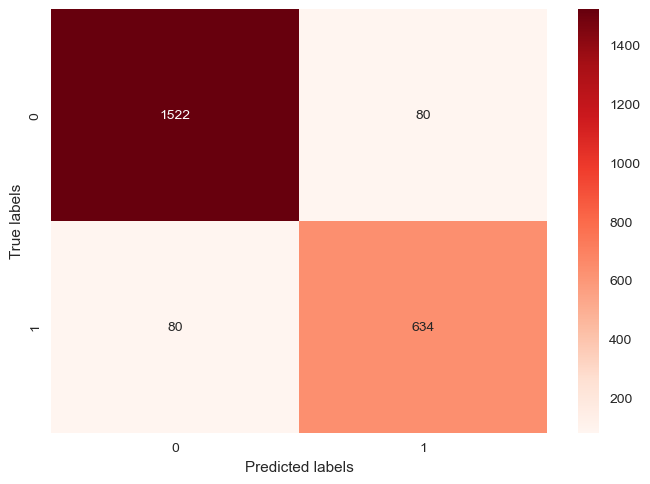

In [39]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [40]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

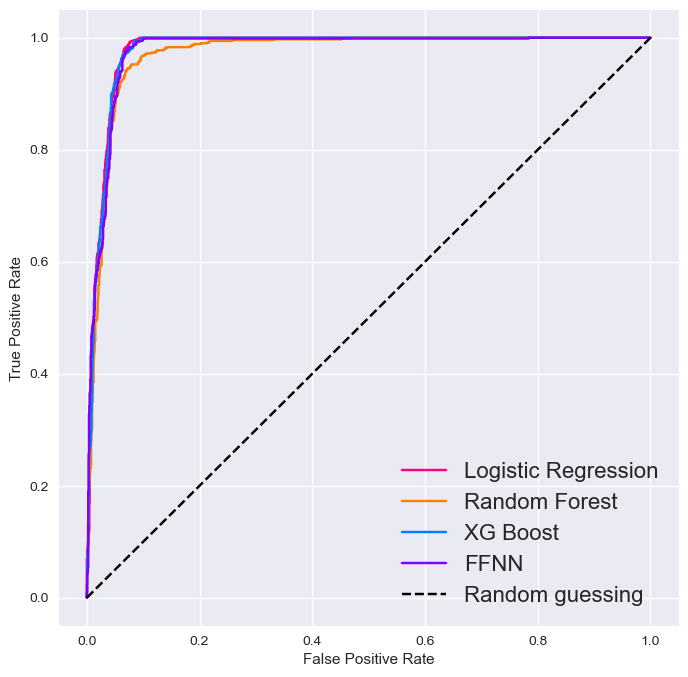

In [41]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff007f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f00")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#007fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f00ff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_eap.png")
plt.show()

## Model Evaluations

In [42]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9452 & 0.9288 & 0.9421 & 0.9309 \\
   Recall & 0.9552 & 0.8824 & 0.9384 & 0.8880 \\
Precision & 0.8777 & 0.8861 & 0.8816 & 0.8880 \\
 F1-Score & 0.9148 & 0.8842 & 0.9091 & 0.8880 \\
      AUC & 0.9805 & 0.9722 & 0.9794 & 0.9777 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [43]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [44]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [45]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-1.817579635333606, 6.692993853339176, 0.110798185325979)

In [46]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [47]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.2265861193991422)

In [48]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-1.7273684683222006, 2.652641723750061, -0.03955133296420933)

In [49]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [50]:
IND_fin["access"] = 1- IND_fin["access"]
#IND_fin["usage"] = 1- IND_fin["usage"]

In [51]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [52]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

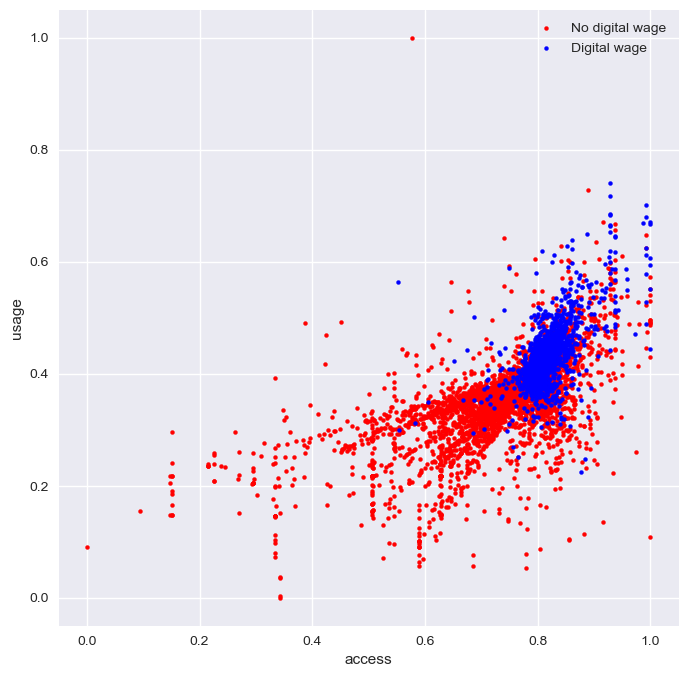

In [53]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.25,1.05])
#plt.ylim([-0.05,.75])
plt.savefig('../../images/find_eap')
plt.show()

In [54]:
IND_fin['access'].describe()

count    11579.000000
mean         0.773414
std          0.077264
min          0.000000
25%          0.765342
50%          0.791950
75%          0.803175
max          1.000000
Name: access, dtype: float64

In [55]:
IND_fin['usage'].describe()

count    11579.000000
mean         0.385345
std          0.057921
min          0.000000
25%          0.365721
50%          0.395148
75%          0.409129
max          1.000000
Name: usage, dtype: float64

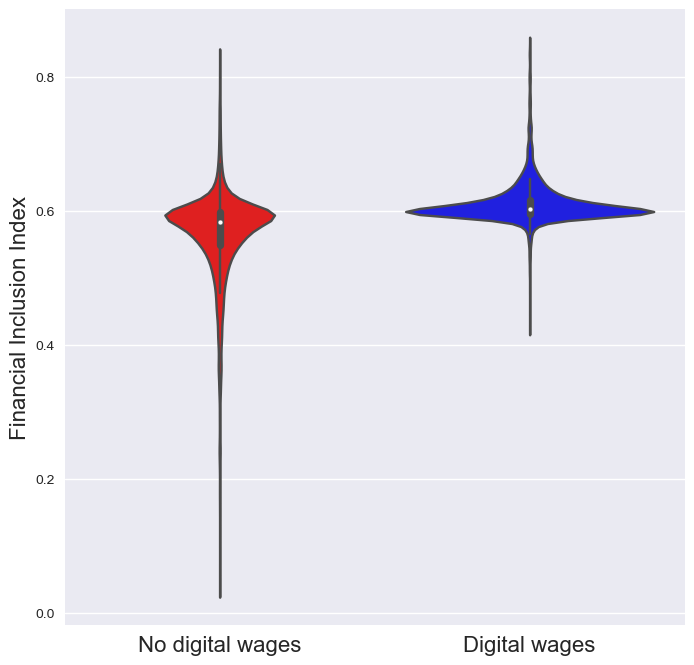

In [56]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)

plt.savefig('../../images/ind_eap')

# Show the plot
plt.show()

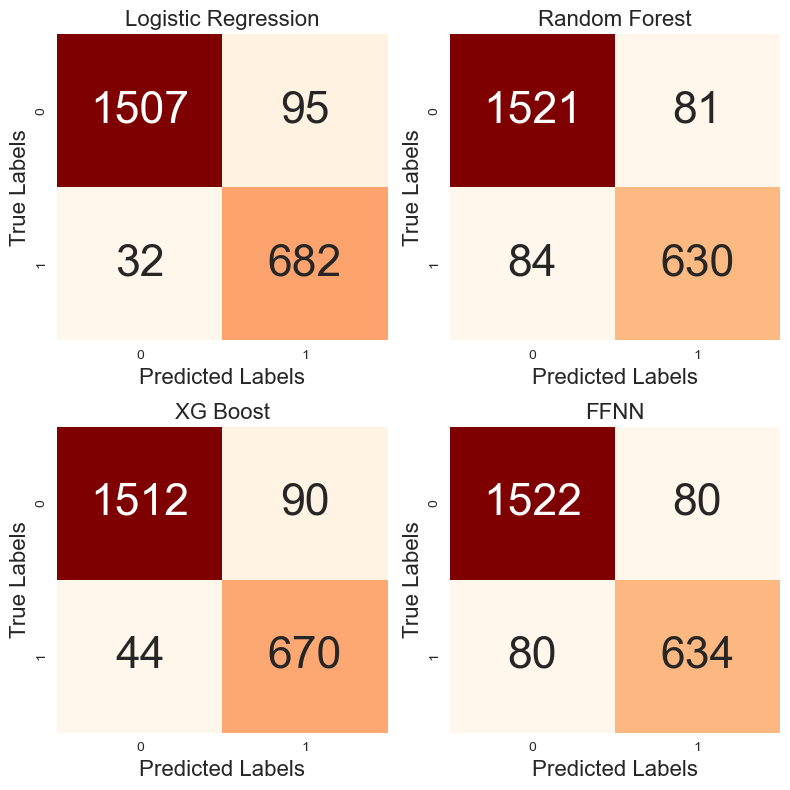

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="OrRd", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_eap.png')
# Display the plot
plt.show()

## Feature Importance

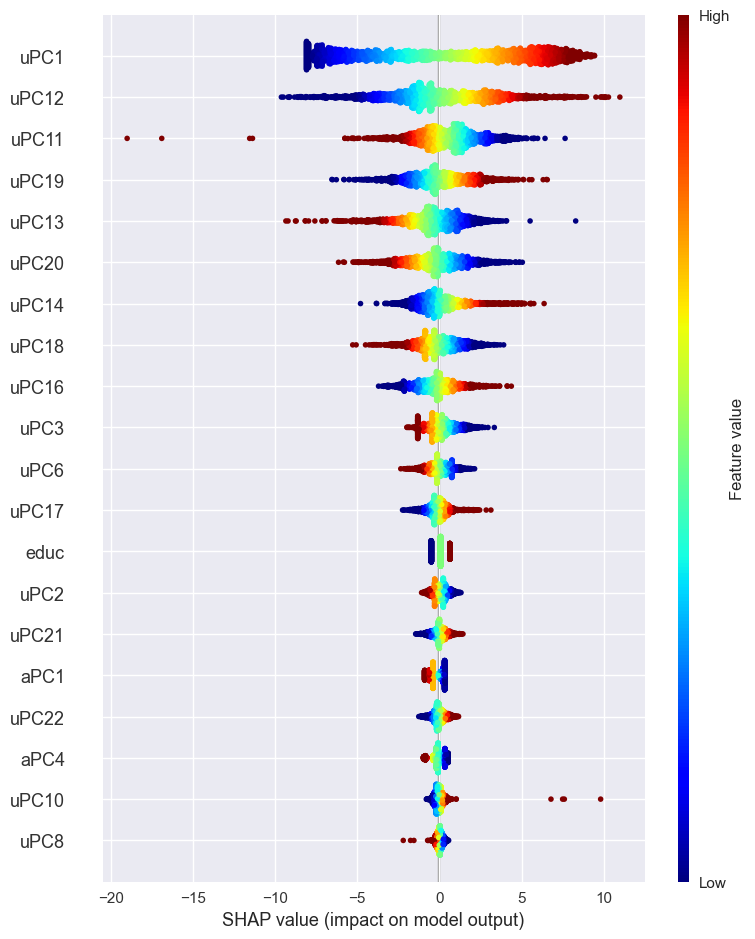

In [58]:
explainer = shap.Explainer(best_lr, X_train)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test, cmap= "jet")

In [59]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

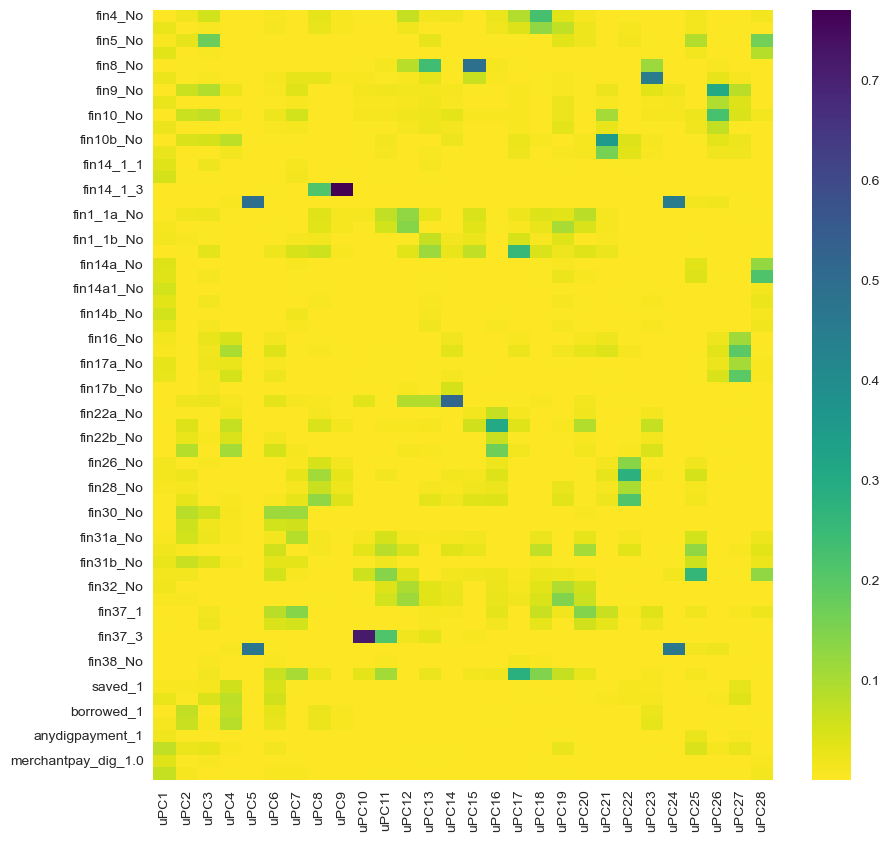

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_eap.png')
plt.show()

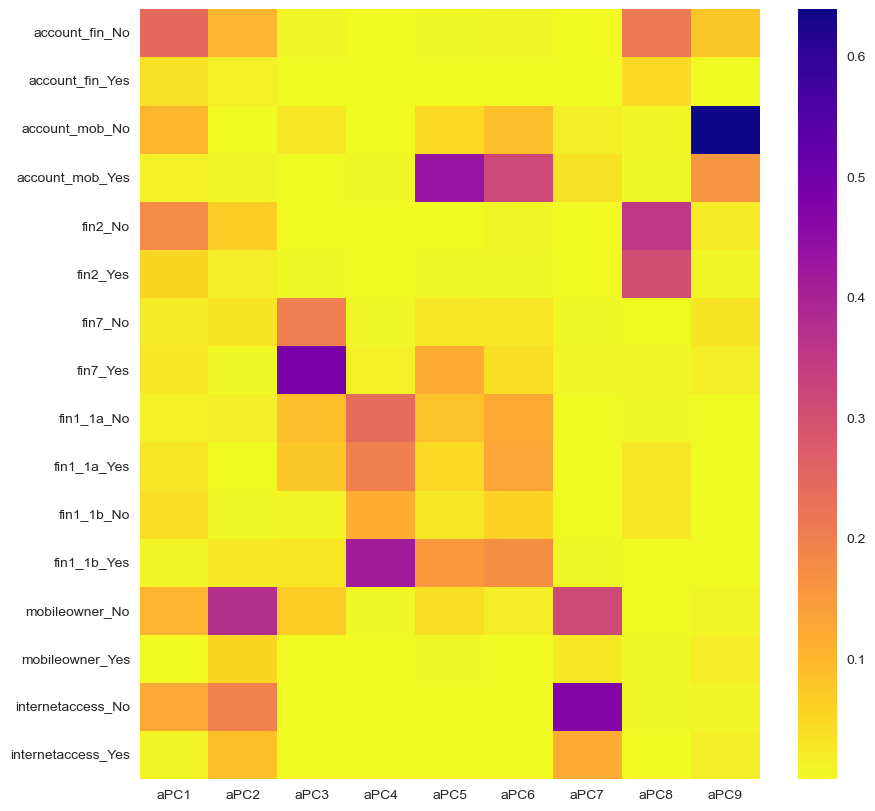

In [61]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_eap.png')
plt.show()

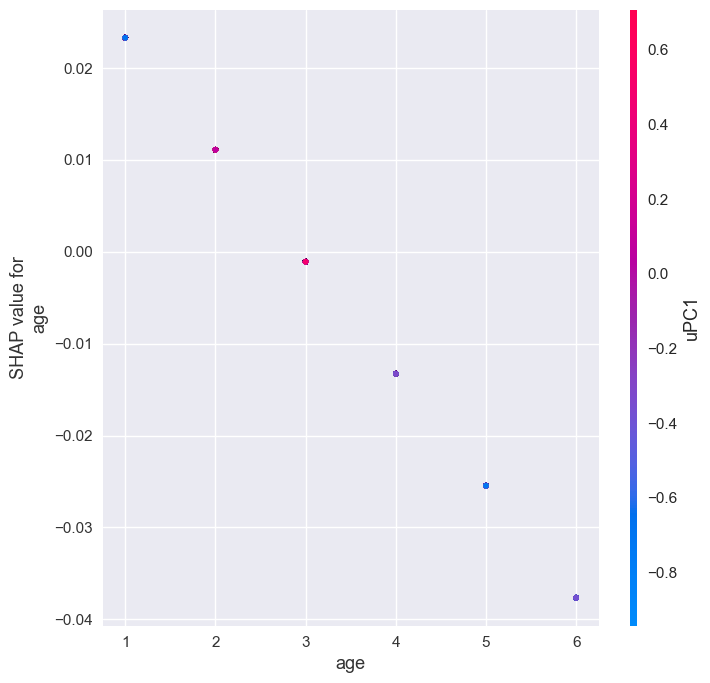

In [62]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

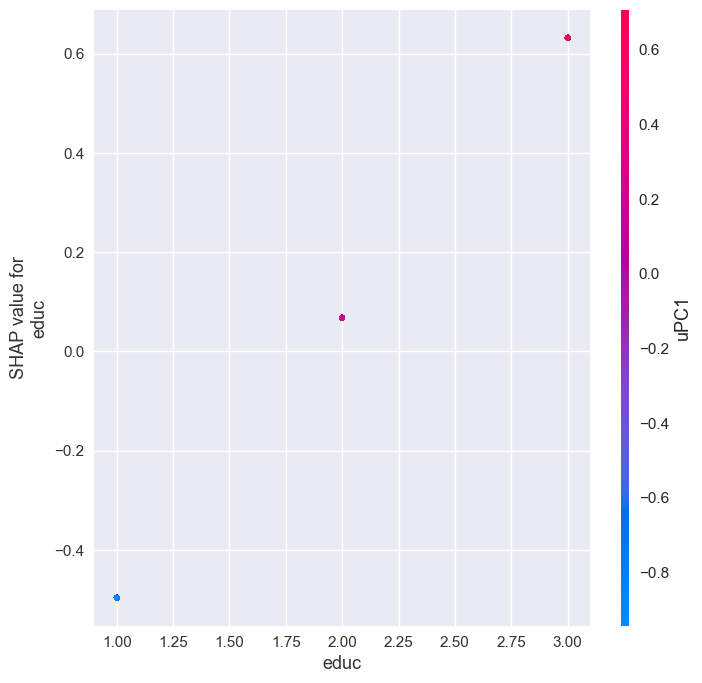

In [63]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

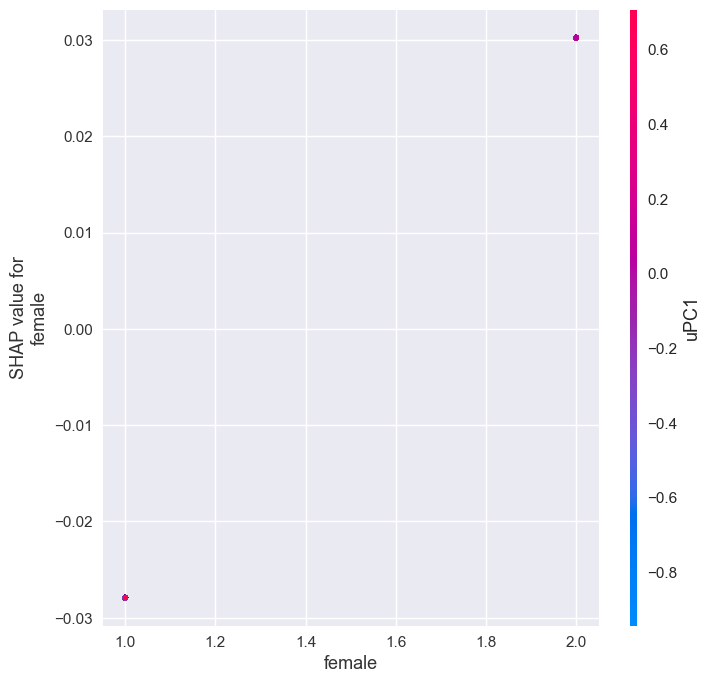

In [64]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

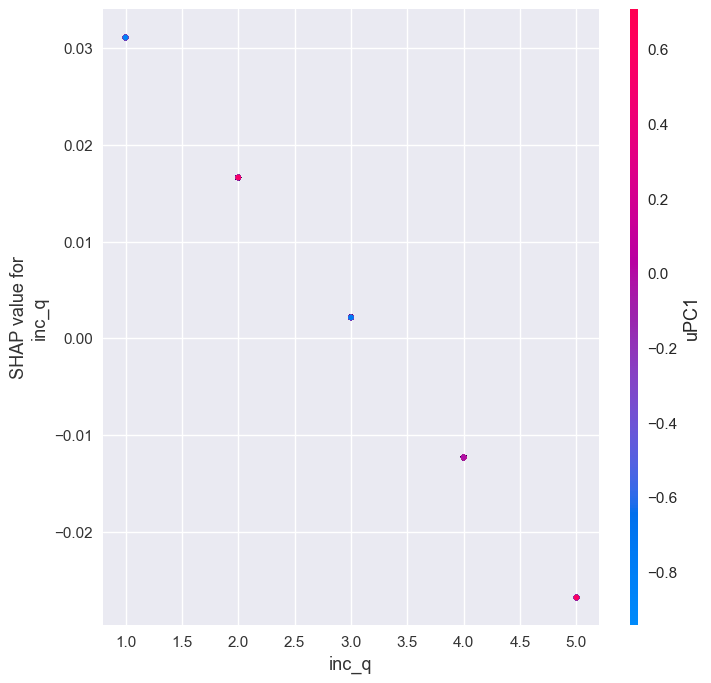

In [65]:
ig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()